In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# **An Efficient Deep Learning Model for Bangla Handwritten Digit Recognition**


> Dataset [**BHand**] : https://github.com/SaadatChowdhury/BHaND

*README*

The full form of BHaND is "Bengali Handwritten Numerals Dataset".

In this work, we have created a new dataset containing images of handwritten Bengali numerals. Our main goal was to make the dataset similar to MNIST, one of the most well-known datasets for English handwritten digits.

Similar to MNIST, we have collected 70,000 sample images of Bengali digits. Each image is 32×32 in size (MNIST images were 28×28). Everything else closely follows the structure of the MNIST dataset.

**Basic Description**

This dataset consists of **70,000** samples divided into three sets:

> **Training set:** 50,000 samples

> **Validation set:** 10,000 samples

> **Test set:** 10,000 samples




Each row in these sets has two components: the first component is the image data, and the second component is the label. The label represents the Bengali digit (0 to 9) shown in the corresponding image. For example, the training set contains 50,000 rows, each with two parts: a 1024-dimensional image vector and an integer label.

All samples are in grayscale and normalized to the intensity range
[0,1]. The pixel intensities were inverted so that black pixels have a value of 1 and white pixels have a value of 0. The images were then flattened into 1024-dimensional vectors (since
32×32=1024).

Finally, all samples were grouped together into a single pickle file using Python's `cPickle` serializer and compressed using the GZIP compression algorithm for faster transmission.



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os
import pandas as pd
from pathlib import Path
import time
import warnings
import gzip
import pickle
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

class BanglaDigitRecognizer:

    def __init__(self, input_shape=(32, 32, 1), num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def create_efficient_model(self):
        """
        Create an efficient CNN architecture optimized for Bangla digits (32x32)
        Based on research findings with custom optimizations
        """
        model = keras.Sequential([
            # Input layer
            layers.Input(shape=self.input_shape),

            # First convolutional block
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Second convolutional block
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Third convolutional block
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Fourth convolutional block (added for 32x32 input)
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Global Average Pooling (more efficient than Flatten)
            layers.GlobalAveragePooling2D(),

            # Dense layers with regularization
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # Output layer
            layers.Dense(self.num_classes, activation='softmax')
        ])

        # Compile with optimized settings
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def create_data_generators(self, train_data, train_labels, validation_split=0.2):
        """
        Create data generators with augmentation for training
        """
        # Data augmentation for training
        train_datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            fill_mode='constant',
            cval=0,
            validation_split=validation_split
        )

        # No augmentation for validation
        val_datagen = keras.preprocessing.image.ImageDataGenerator(
            validation_split=validation_split
        )

        train_generator = train_datagen.flow(
            train_data, train_labels,
            batch_size=32,
            subset='training'
        )

        val_generator = val_datagen.flow(
            train_data, train_labels,
            batch_size=32,
            subset='validation'
        )

        return train_generator, val_generator

    def get_callbacks(self, model_path='best_bangla_model.h5'):
        """
        Create training callbacks for optimal performance
        """
        callbacks_list = [
            # Save best model
            callbacks.ModelCheckpoint(
                model_path,
                monitor='val_accuracy',
                save_best_only=True,
                save_weights_only=False,
                verbose=1
            ),

            # Reduce learning rate on plateau
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),

            # Early stopping
            callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),

            # Learning rate scheduler
            callbacks.LearningRateScheduler(
                lambda epoch: 0.001 * (0.95 ** epoch)
            )
        ]

        return callbacks_list

    def train(self, train_data, train_labels, epochs=50, validation_split=0.2):
        """
        Train the model with optimized settings
        """
        if self.model is None:
            self.create_efficient_model()

        print("Creating data generators...")
        train_gen, val_gen = self.create_data_generators(
            train_data, train_labels, validation_split
        )

        print("Setting up callbacks...")
        callback_list = self.get_callbacks()

        print("Starting training...")
        start_time = time.time()

        self.history = self.model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            callbacks=callback_list,
            verbose=1
        )

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")

        return self.history

    def evaluate_model(self, test_data, test_labels):
        """
        Comprehensive model evaluation
        """
        if self.model is None:
            raise ValueError("Model not trained yet!")

        print("Evaluating model...")

        # Basic evaluation
        test_loss, test_accuracy = self.model.evaluate(
            test_data, test_labels, verbose=0
        )

        # Predictions
        predictions = self.model.predict(test_data, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)

        # Classification report
        class_names = [str(i) for i in range(10)]
        report = classification_report(
            test_labels, predicted_classes,
            target_names=class_names,
            output_dict=True
        )

        # Confusion matrix
        cm = confusion_matrix(test_labels, predicted_classes)

        results = {
            'test_accuracy': test_accuracy,
            'test_loss': test_loss,
            'classification_report': report,
            'confusion_matrix': cm,
            'predictions': predictions,
            'predicted_classes': predicted_classes
        }

        return results

    def plot_training_history(self):
        """
        Plot training history
        """
        if self.history is None:
            print("No training history available!")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy plot
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        # Loss plot
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, cm):
        """
        Plot confusion matrix
        """
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10)
        )
        plt.title('Confusion Matrix - Bangla Digit Recognition')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    def plot_sample_predictions(self, test_data, test_labels, num_samples=10):
        """
        Plot sample predictions
        """
        if self.model is None:
            raise ValueError("Model not trained yet!")

        # Get random samples
        indices = np.random.choice(len(test_data), num_samples, replace=False)
        sample_images = test_data[indices]
        sample_labels = test_labels[indices]

        # Make predictions
        predictions = self.model.predict(sample_images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        confidences = np.max(predictions, axis=1)

        # Plot
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()

        for i in range(num_samples):
            axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
            axes[i].set_title(
                f'True: {sample_labels[i]}, Pred: {predicted_classes[i]}\n'
                f'Confidence: {confidences[i]:.3f}'
            )
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    def predict_single_image(self, image_path_or_array):
        """
        Predict a single image
        """
        if self.model is None:
            raise ValueError("Model not trained yet!")

        if isinstance(image_path_or_array, str):
            # Load image from path
            image = cv2.imread(image_path_or_array, cv2.IMREAD_GRAYSCALE)
            if image is None:
                raise ValueError(f"Could not load image from {image_path_or_array}")
        else:
            image = image_path_or_array

        # Preprocess image
        image = cv2.resize(image, (32, 32))
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=[0, -1])

        # Predict
        prediction = self.model.predict(image, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        return predicted_class, confidence

    def save_model(self, filepath='bangla_digit_model.h5'):
        """
        Save the trained model
        """
        if self.model is None:
            raise ValueError("No model to save!")

        self.model.save(filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath='bangla_digit_model.h5'):
        """
        Load a pre-trained model
        """
        self.model = keras.models.load_model(filepath)
        print(f"Model loaded from {filepath}")

def load_bhand_dataset(data_path):

    print("Loading BHAND dataset from pickled file...")

    try:
        # Load the pickled dataset
        with gzip.open(data_path, 'rb') as f:
            train_set, valid_set, test_set = pickle.load(f,encoding = 'latin1')


        # Extract data and labels
        train_data, train_labels = train_set
        val_data, val_labels = valid_set
        test_data, test_labels = test_set

        # Convert to numpy arrays if they aren't already
        train_data = np.array(train_data, dtype='float32')
        train_labels = np.array(train_labels, dtype='int32')
        val_data = np.array(val_data, dtype='float32')
        val_labels = np.array(val_labels, dtype='int32')
        test_data = np.array(test_data, dtype='float32')
        test_labels = np.array(test_labels, dtype='int32')

        # Check if normalization is needed (values should be 0-1)
        if train_data.max() > 1.5:  # Likely 0-255 range
            print("Normalizing pixel values from 0-255 to 0-1...")
            train_data = train_data / 255.0
            val_data = val_data / 255.0
            test_data = test_data / 255.0

        # Determine image dimensions and reshape if necessary
        # BHAND images are typically 32x32 or flattened 1024-dimensional vectors
        if len(train_data.shape) == 2:  # Flattened images (N, 1024)
            img_size = int(np.sqrt(train_data.shape[1]))  # Should be 32 for 1024 features
            print(f"Reshaping flattened images to {img_size}x{img_size}...")

            train_data = train_data.reshape(-1, img_size, img_size, 1)
            val_data = val_data.reshape(-1, img_size, img_size, 1)
            test_data = test_data.reshape(-1, img_size, img_size, 1)
        elif len(train_data.shape) == 3:  # Images without channel dimension (N, H, W)
            print("Adding channel dimension...")
            train_data = np.expand_dims(train_data, axis=-1)
            val_data = np.expand_dims(val_data, axis=-1)
            test_data = np.expand_dims(test_data, axis=-1)

        print(f"Training data shape: {train_data.shape}")
        print(f"Validation data shape: {val_data.shape}")
        print(f"Test data shape: {test_data.shape}")
        print(f"Number of classes: {len(np.unique(train_labels))}")
        print(f"Label range: {train_labels.min()} to {train_labels.max()}")

        # Combine train and validation sets for training (since the model will split internally)
        combined_train_data = np.concatenate([train_data, val_data], axis=0)
        combined_train_labels = np.concatenate([train_labels, val_labels], axis=0)

        return combined_train_data, combined_train_labels, test_data, test_labels

    except FileNotFoundError:
        print(f"❌ Dataset file not found at: {data_path}")
        print("Please ensure 'bhand.pkl.gz' is in the specified path")
        raise
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        print("Please check if the file format is correct")
        raise

def create_sample_images(test_data, test_labels, num_samples=20):
    """
    Create sample images for visualization
    """
    indices = np.random.choice(len(test_data), num_samples, replace=False)
    sample_images = test_data[indices]
    sample_labels = test_labels[indices]

    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Digit: {sample_labels[i]}')
        axes[i].axis('off')

    plt.suptitle('Sample Bangla Digits from Dataset')
    plt.tight_layout()
    plt.show()

def analyze_dataset(train_data, train_labels, test_data, test_labels):
    """
    Analyze and visualize dataset statistics
    """
    print("\n📊 Dataset Analysis:")
    print("=" * 40)

    # Class distribution
    unique_labels, train_counts = np.unique(train_labels, return_counts=True)
    unique_labels_test, test_counts = np.unique(test_labels, return_counts=True)

    # Create distribution plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Training set distribution
    ax1.bar(unique_labels, train_counts, alpha=0.7, color='skyblue')
    ax1.set_title('Training Set Class Distribution')
    ax1.set_xlabel('Digit Class')
    ax1.set_ylabel('Number of Samples')
    ax1.grid(True, alpha=0.3)

    # Test set distribution
    ax2.bar(unique_labels_test, test_counts, alpha=0.7, color='lightcoral')
    ax2.set_title('Test Set Class Distribution')
    ax2.set_xlabel('Digit Class')
    ax2.set_ylabel('Number of Samples')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Total training samples: {len(train_data):,}")
    print(f"Total test samples: {len(test_data):,}")
    print(f"Image shape: {train_data.shape[1:]}")
    print(f"Number of classes: {len(unique_labels)}")

    print("\nClass distribution (Training):")
    for label, count in zip(unique_labels, train_counts):
        percentage = (count / len(train_labels)) * 100
        print(f"  Digit {label}: {count:,} samples ({percentage:.1f}%)")

def main():
    """
    Main training and evaluation pipeline
    """
    print("🔥 Efficient Bangla Digit Recognition System 🔥")
    print("=" * 50)

    # Configuration
    DATASET_PATH = "/content/drive/MyDrive/CSE463/Project/bhand.pkl.gz"  # Path to the pickled dataset file
    MODEL_SAVE_PATH = "bangla_digit_model_efficient.h5"
    EPOCHS = 50

    try:
        # Load dataset
        train_data, train_labels, test_data, test_labels = load_bhand_dataset(DATASET_PATH)

        # Analyze dataset
        analyze_dataset(train_data, train_labels, test_data, test_labels)

        # Show sample images
        print("\n🖼️  Displaying sample images...")
        create_sample_images(test_data, test_labels)

        # Create and train model
        recognizer = BanglaDigitRecognizer()

        print("\n📊 Model Architecture:")
        model = recognizer.create_efficient_model()
        model.summary()

        print(f"\n🚀 Training model for {EPOCHS} epochs...")
        history = recognizer.train(
            train_data, train_labels,
            epochs=EPOCHS,
            validation_split=0.2
        )

        # Evaluate model
        print("\n📈 Evaluating model...")
        results = recognizer.evaluate_model(test_data, test_labels)

        print(f"\n🎯 Test Accuracy: {results['test_accuracy']:.4f}")
        print(f"📉 Test Loss: {results['test_loss']:.4f}")

        # Plot results
        print("\n📊 Plotting training history...")
        recognizer.plot_training_history()

        print("\n🔍 Plotting confusion matrix...")
        recognizer.plot_confusion_matrix(results['confusion_matrix'])

        print("\n🖼️  Sample predictions...")
        recognizer.plot_sample_predictions(test_data, test_labels)

        # Save model
        recognizer.save_model(MODEL_SAVE_PATH)

        print("\n✅ Training completed successfully!")
        print(f"Model saved as: {MODEL_SAVE_PATH}")

        # Show detailed classification report
        print("\n📋 Detailed Classification Report:")
        print("-" * 50)
        for class_name, metrics in results['classification_report'].items():
            if isinstance(metrics, dict) and class_name.isdigit():
                print(f"Digit {class_name}:")
                print(f"  Precision: {metrics['precision']:.4f}")
                print(f"  Recall:    {metrics['recall']:.4f}")
                print(f"  F1-Score:  {metrics['f1-score']:.4f}")
                print()

        # Overall metrics
        if 'accuracy' in results['classification_report']:
            overall_acc = results['classification_report']['accuracy']
            print(f"Overall Accuracy: {overall_acc:.4f}")

        if 'macro avg' in results['classification_report']:
            macro_avg = results['classification_report']['macro avg']
            print(f"Macro Average F1: {macro_avg['f1-score']:.4f}")

        # Performance summary
        print("\n📊 Performance Summary:")
        print("-" * 30)
        print(f"🎯 Test Accuracy: {results['test_accuracy']:.2%}")
        print(f"📉 Test Loss: {results['test_loss']:.4f}")
        print(f"🔢 Total Parameters: {model.count_params():,}")

        # Create inference example
        print("\n🚀 Testing single image prediction...")
        # Use a random test image for demonstration
        random_idx = np.random.randint(0, len(test_data))
        test_image = test_data[random_idx]
        true_label = test_labels[random_idx]

        predicted_digit, confidence = recognizer.predict_single_image(test_image)
        print(f"True digit: {true_label}")
        print(f"Predicted digit: {predicted_digit}")
        print(f"Confidence: {confidence:.3f}")
        print(f"Correct: {'✅' if predicted_digit == true_label else '❌'}")

    except Exception as e:
        print(f"❌ Error: {e}")
        print("Please ensure the BHAND dataset file 'bhand.pkl.gz' is in the current directory.")
        print("Dataset should be available at: https://github.com/SaadatChowdhury/BHaND")
        print("Make sure to use Python 2/3 compatible pickle loading if needed.")

# Additional utility functions
def benchmark_model(recognizer, test_data, num_samples=1000):
    """
    Benchmark model inference speed
    """
    print(f"\n⚡ Benchmarking inference speed with {num_samples} samples...")

    # Select random samples
    indices = np.random.choice(len(test_data), min(num_samples, len(test_data)), replace=False)
    benchmark_data = test_data[indices]

    # Time the inference
    start_time = time.time()
    predictions = recognizer.model.predict(benchmark_data, verbose=0)
    end_time = time.time()

    total_time = end_time - start_time
    avg_time = total_time / len(benchmark_data)
    fps = len(benchmark_data) / total_time

    print(f"Total inference time: {total_time:.3f} seconds")
    print(f"Average time per image: {avg_time*1000:.2f} ms")
    print(f"Inference speed: {fps:.1f} FPS")

def export_model_info(recognizer, filepath='model_info.txt'):
    """
    Export model information to text file
    """
    if recognizer.model is None:
        print("No model to export info for!")
        return

    with open(filepath, 'w') as f:
        f.write("Bangla Digit Recognition Model Information\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Model Architecture: CNN with Batch Normalization\n")
        f.write(f"Input Shape: {recognizer.input_shape}\n")
        f.write(f"Number of Classes: {recognizer.num_classes}\n")
        f.write(f"Total Parameters: {recognizer.model.count_params():,}\n")
        f.write(f"Model Size: {os.path.getsize('bangla_digit_model_efficient.h5') / (1024*1024):.2f} MB\n")

        if recognizer.history:
            final_acc = recognizer.history.history['accuracy'][-1]
            final_val_acc = recognizer.history.history['val_accuracy'][-1]
            f.write(f"Final Training Accuracy: {final_acc:.4f}\n")
            f.write(f"Final Validation Accuracy: {final_val_acc:.4f}\n")

    print(f"Model information exported to {filepath}")

if __name__ == "__main__":
    main()


# **Percentage-Point Gap (pp)**

percentage-point gap between the final training accuracy and the final validation (or test) accuracy:
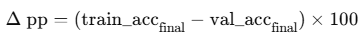

*Practical Rule of Thumb:*
> **|Δ pp| < 0.3 → model generalises perfectly, indicating no measurable over-fitting.**



In [ ]:
# 1. reload the trained model
rec = BanglaDigitRecognizer()
rec.load_model("bangla_digit_model_efficient.h5")

# 2. reload the dataset
train_x, train_y, _, _ = load_bhand_dataset("/content/drive/MyDrive/CSE463/Project/bhand.pkl.gz")

# 3. recreate the 80/20 split that ImageDataGenerator used
split = int(len(train_x) * 0.8)
x_train_part, y_train_part = train_x[:split], train_y[:split]
x_val_part,   y_val_part   = train_x[split:], train_y[split:]

# 4. evaluate
train_acc = rec.model.evaluate(x_train_part, y_train_part, verbose=0)[1]
val_acc   = rec.model.evaluate(x_val_part,   y_val_part,   verbose=0)[1]
delta_pp  = (train_acc - val_acc) * 100
print(f"Δ pp (train – val) = {delta_pp:.2f}")


# **BHAND comparisons**

In [ ]:
# ╔══════════════════════════════════════════════════════════════════╗
# ║        BHAND BENCHMARK  –  EfficientCNN + AlexNet + LeNet + MBV2 ║
# ╚══════════════════════════════════════════════════════════════════╝
import os, time, pathlib, warnings, numpy as np, pandas as pd, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
warnings.filterwarnings("ignore")
tf.random.set_seed(42); np.random.seed(42)

# ────────────────────────────────────────────────────────────────────
# 0  Dataset + EfficientCNN
# ────────────────────────────────────────────────────────────────────
DATASET_PATH = "/content/drive/MyDrive/CSE463/Project/bhand.pkl.gz"
EFF_H5       = pathlib.Path("bangla_digit_model_efficient.h5")
CKPT_DIR     = pathlib.Path("checkpoints"); CKPT_DIR.mkdir(exist_ok=True)

train_x, train_y, test_x, test_y = load_bhand_dataset(DATASET_PATH)

rec = BanglaDigitRecognizer(); rec.create_efficient_model()
rec.load_model(EFF_H5)
# (compile once so loss/metric objects exist)
rec.model.compile("adam","sparse_categorical_crossentropy",
                  metrics=["sparse_categorical_accuracy"])
eff_model = rec.model

# ────────────────────────────────────────────────────────────────────
# 1  Baseline builders
# ────────────────────────────────────────────────────────────────────
def build_lenet():
    m = keras.Sequential(name="LeNet5")
    m.add(layers.Conv2D(6,5,padding="same",activation="relu",input_shape=(32,32,1)))
    m.add(layers.AveragePooling2D(2)); m.add(layers.Conv2D(16,5,activation="relu"))
    m.add(layers.AveragePooling2D(2)); m.add(layers.Flatten())
    m.add(layers.Dense(120,activation="relu"))
    m.add(layers.Dense(84,activation="relu"))
    m.add(layers.Dense(10,activation="softmax"))
    return m

def build_alexnet():
    m = keras.Sequential(name="AlexNetBHAND")
    m.add(layers.Conv2D(96,3,padding="same",activation="relu",input_shape=(32,32,1)))
    m.add(layers.BatchNormalization()); m.add(layers.MaxPooling2D(2))
    m.add(layers.Conv2D(256,3,padding="same",activation="relu"))
    m.add(layers.BatchNormalization()); m.add(layers.MaxPooling2D(2))
    m.add(layers.Conv2D(384,3,padding="same",activation="relu"))
    m.add(layers.Conv2D(384,3,padding="same",activation="relu"))
    m.add(layers.Conv2D(256,3,padding="same",activation="relu"))
    m.add(layers.MaxPooling2D(2)); m.add(layers.Flatten())
    m.add(layers.Dense(512,activation="relu")); m.add(layers.Dropout(0.5))
    m.add(layers.Dense(512,activation="relu")); m.add(layers.Dropout(0.5))
    m.add(layers.Dense(10,activation="softmax"))
    return m

def build_mobilenet(alpha=0.5):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(32,32,3), alpha=alpha, include_top=False, weights=None)
    m = keras.Sequential(name=f"MobileNetV2_{alpha}")
    m.add(layers.Input((32,32,1)))
    m.add(layers.Conv2D(3,(1,1),padding="same"))
    m.add(base); m.add(layers.GlobalAveragePooling2D())
    m.add(layers.Dense(10,activation="softmax"))
    return m

# ────────────────────────────────────────────────────────────────────
# 2  Safe trainer / loader
# ────────────────────────────────────────────────────────────────────
def prep(model, x, y, epochs, h5):
    x = x.astype("float32"); y = y.astype("int32")
    if pathlib.Path(h5).exists():
        model.load_weights(h5); print(f"✓ Loaded {pathlib.Path(h5).name}")
    else:
        model.compile("adam","sparse_categorical_crossentropy",
                      metrics=["sparse_categorical_accuracy"])
        model.fit(x, y, epochs=epochs, batch_size=64,
                  validation_split=0.1, verbose=2)
        model.save(h5)
    return model

alex_model   = prep(build_alexnet(),      train_x, train_y, 40, CKPT_DIR/"AlexNet.h5")
lenet_model  = prep(build_lenet(),        train_x, train_y, 20, CKPT_DIR/"LeNet5.h5")
mobile_model = prep(build_mobilenet(0.5), train_x, train_y, 30, CKPT_DIR/"MobileNetV2.h5")

# ────────────────────────────────────────────────────────────────────
# 3  Evaluation helper (auto-compile if needed)
# ────────────────────────────────────────────────────────────────────
def evaluate(model, x, y, h5):
    model.compile(                       # compile every time (cheap)
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"]
    )
    acc = model.evaluate(x, y, verbose=0)[1]
    t0 = time.time(); model.predict(x[:1024], verbose=0); lat = (time.time()-t0)/1024*1000
    size = pathlib.Path(h5).stat().st_size/1_048_576
    return acc, model.count_params(), lat, size

# ────────────────────────────────────────────────────────────────────
# 4  FLOP counter  – returns None if profiling not available
# ────────────────────────────────────────────────────────────────────
def safe_flops(model):
    try:
        g = tf.function(lambda x: model(x)).get_concrete_function(
                tf.TensorSpec([1,32,32,1], tf.float32)).graph
        return tf.profiler.experimental.get_stats(g)['total_flops']/1e6
    except Exception:
        return None

# ────────────────────────────────────────────────────────────────────
# 5  Collect metrics
# ────────────────────────────────────────────────────────────────────
rows = {}
for name, mdl, h5 in [
        ("EfficientCNN",   eff_model,   EFF_H5),
        ("AlexNet",        alex_model,  CKPT_DIR/"AlexNet.h5"),
        ("LeNet5",         lenet_model, CKPT_DIR/"LeNet5.h5"),
        ("MobileNetV2-0.5",mobile_model,CKPT_DIR/"MobileNetV2.h5")]:
    acc, params, lat, size = evaluate(mdl, test_x, test_y, h5)
    flop_val = safe_flops(mdl)
    rows[name] = dict(
        accuracy = round(acc,4),
        params   = params,
        FLOPs_M  = "-" if flop_val is None else round(flop_val,1),
        lat_ms   = round(lat,3),
        size_mb  = round(size,2)
    )

df = pd.DataFrame(rows).T
df.to_csv("benchmark_with_flops.csv")

print("\n=== BHAND Benchmark ===")
print(df.to_string())
